# Regenerating Figure 1 from Stefansson et al. 2023

# Importing Packages 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

import sys
sys.path.append('../src/')
import utils
reload(utils)
import lomb_scargle_plot
import spec_help

# First run the script in the scripts/ directory called scripts/run_lhs3154.sh
- This will extract the RVs and create a folder called website/uploading_RC/data/targets/LHS_3154/results/
- RVs are located in the following files: 
- ../website/uploading_RC/data/targets/LHS_3154/results/LHS_3154_rv_unbin.csv (unbinned RVs)
- ../website/uploading_RC/data/targets/LHS_3154/results/LHS_3154_rv_bin.csv (binned RVs per HET track)

# Regenerate Figure 1 from paper 
- This will read in model results from running the juliet code on the data.
- The juliet outputs are found in the ../input_data/lhs_3154_juliet/juliet_run/ folder 

Best period: 	3.71871339
Best frequency: 0.26891021
Best power: 	0.80735233
Model amplitude: 23.08988288
Calculating window function


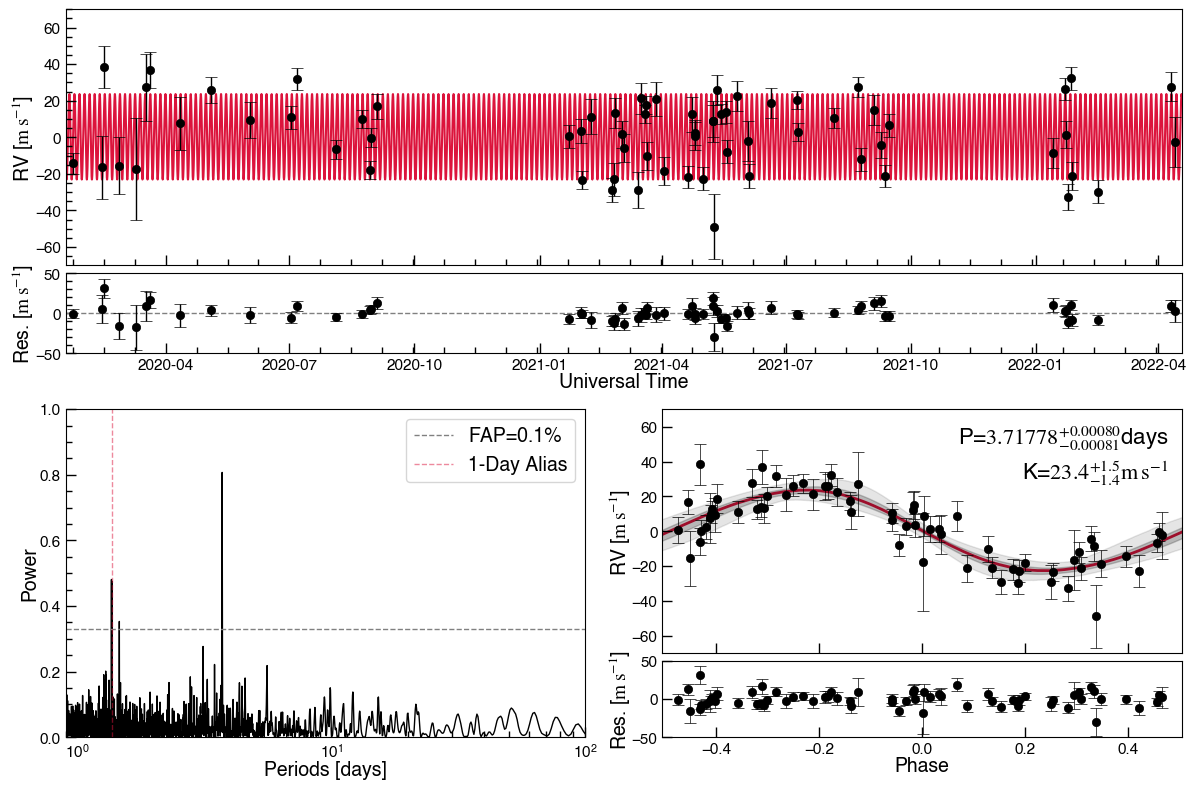

In [2]:
import matplotlib
matplotlib.rc_file(matplotlib.matplotlib_fname())
%matplotlib inline
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'Helvetica'
rcParams['font.weight'] = "normal"
rcParams["axes.formatter.useoffset"] = False
rcParams['xtick.major.width']=1
rcParams['xtick.major.size']=7
rcParams['xtick.minor.width']=1
rcParams['xtick.minor.size']=4
rcParams['ytick.major.width']=1
rcParams['ytick.major.size']=7
rcParams['ytick.minor.width']=1
rcParams['ytick.minor.size']=4
rcParams['xtick.direction']='in'
rcParams['ytick.direction']='in'
rcParams['axes.formatter.limits'] = -10,10

from matplotlib.gridspec import GridSpec
import matplotlib as mpl
PW,PH = 12., 8.
mpl.rc('axes', labelsize=7, titlesize=8)
mpl.rc('font', size=6)
mpl.rc('xtick', labelsize=11)
mpl.rc('ytick', labelsize=11)
mpl.rc('lines', linewidth=1)

fig = plt.figure(figsize=(PW,PH))
gs1 = GridSpec(4,1)
gs1.update(top=0.97, bottom = 0.54,hspace=0.1,left=0.05,right=0.98,wspace=0.05)

gs2 = GridSpec(4,4)
gs2.update(top=0.47, bottom = 0.06,hspace=0.1,left=0.05,right=0.98,wspace=0.35)

ax1  = plt.subplot(gs1[0:3,0])
ax2  = plt.subplot(gs1[3,0])
bx1  = plt.subplot(gs2[:,:2])
cx1  = plt.subplot(gs2[0:3,2:])
cx2  = plt.subplot(gs2[3,2:])


dcolor = 'black'
tsize = 14

######################################
# Model - Joint Unphased
######################################
df_d = pd.read_csv("../input_data/lhs_3154_juliet/juliet_run/time_rv_data.dat",
            delim_whitespace=True,header=None,comment="#",names=["bjd","rv","rverr","gp","model","inst"])
df_m = pd.read_csv("../input_data/lhs_3154_juliet/juliet_run/time_rv_model.dat",
            delim_whitespace=True,header=None,comment="#",names=["bjd","gp","gprv",'m1d','m1u','m2d','m2u','m3d','m3u'])
ax1.errorbar(utils.jd2datetime(df_d.bjd),df_d.rv,df_d.rverr,elinewidth=1,mew=0.5,capsize=4,marker="o",lw=0,color=dcolor,label="HPF RVs",zorder=10)
ax1.set_xlim(utils.jd2datetime([df_d.bjd.values[0]-5]),utils.jd2datetime([df_d.bjd.values[-1]+5]))
ax2.errorbar(utils.jd2datetime(df_d.bjd),df_d.rv-df_d.model,df_d.rverr,elinewidth=1,mew=0.5,capsize=4,marker="o",lw=0,color=dcolor,label="HPF RVs",zorder=10)
_xlim = ax1.get_xlim()
ax1.set_xlim(*_xlim)
ax2.set_xlim(*_xlim)

df_res = utils.read_juliet_posterior('../input_data/lhs_3154_juliet/juliet_run/posteriors.dat')
P = df_res[df_res.labels=='P_p1']['medvals'].values[0]
Tc = df_res[df_res.labels=='t0_p1']['medvals'].values[0]
ecc = df_res[df_res.labels=='ecc_p1']['medvals'].values[0]
omega = df_res[df_res.labels=='omega_p1']['medvals'].values[0]
K = df_res[df_res.labels=='K_p1']['medvals'].values[0]
tt = np.linspace(df_d.bjd.values[0]-10,df_d.bjd.values[-1]+10,10000)
RV = utils.get_rv_curve(tt,P,Tc,ecc,omega,K)

ax1.plot(utils.jd2datetime(tt),RV,color="crimson",lw=1.5,label="Model",zorder=1,alpha=1.)
ax2.axhline(0,color='grey',linestyle='--',lw=1)


######################################
# GLS
######################################
df = pd.read_csv('../input_data/lhs_3154_juliet/juliet_run/rvs.dat',delim_whitespace=True,names=['bjd','rv','e_rv','inst'])
L = lomb_scargle_plot.LombScarglePlot(df.bjd.values,df.rv.values,df.e_rv.values)
L.calc_lomb_scargle()


bx1.plot(L.periods,L.power,color='black')
bx1.set_xscale('log')
bx1.set_xlabel('Periods [days]',fontsize=14,labelpad=0)
bx1.set_ylabel('Power',fontsize=14,labelpad=0)
bx1.set_xlim(0.9,100)

fa_3 = L.L.false_alarm_level(0.001)  
bx1.axhline(fa_3,label='FAP=0.1%',color='grey',linestyle='--',lw=1)

P_alias = utils.alias_from_1day(P)
bx1.axvline(P_alias,color='crimson',linestyle='--',alpha=0.5,lw=1,label='1-Day Alias')
bx1.legend(loc='upper right',fontsize=14)
bx1.set_ylim(0,1)

######################################
# Model - Planet b
######################################
df_d = pd.read_csv("../input_data/lhs_3154_juliet/juliet_run/phased_rv_planet1.dat",
            delim_whitespace=True,header=None,comment="#",names=["phase","bjd","rv","rverr","model","inst"])
df_m = pd.read_csv("../input_data/lhs_3154_juliet/juliet_run/phased_rv_planet1_model.dat",
            delim_whitespace=True,header=None,comment="#",names=["phases","model",'m1d','m1u','m2d','m2u','m3d','m3u'])
cx1.errorbar(df_d.phase,df_d.rv,df_d.rverr,elinewidth=0.5,mew=0.5,capsize=4,
             marker="o",lw=0,color=dcolor,label="HPF RVs",zorder=10,alpha=1)
cx1.plot(df_m.phases,df_m.model,color="crimson",lw=2,label="GP Component",zorder=1)
cx1.fill_between(df_m.phases,df_m.m1u,df_m.m1d,color='black',alpha=0.20)
cx1.fill_between(df_m.phases,df_m.m3u,df_m.m3d,color='black',alpha=0.10)
cx2.errorbar(df_d.phase,df_d.rv-df_d.model,df_d.rverr,elinewidth=0.5,
             mew=0.5,capsize=4,marker="o",lw=0,color=dcolor,label="HPF RVs")
df_d = df_d.sort_values('phase').reset_index(drop=True)
df_bin = spec_help.bin_data_with_errors(df_d.phase.values,df_d.rv.values,df_d.rverr.values,3)

label = r'P={}days'.format(df_res[df_res.labels=='P_p1'].latex.values[0])
cx1.text(0.48,50,label,fontsize=16,horizontalalignment="right",)

label = r'K={}'.format(df_res[df_res.labels=='K_p1'].latex.values[0]+'$\mathrm{m\:s^{-1}}$')
cx1.text(0.48,30,label,fontsize=16,horizontalalignment="right",)

df_bin = spec_help.bin_data_with_errors(df_d.phase.values,df_d.rv.values,df_d.rverr.values,3)

for xx in [ax1,cx1]:
    xx.set_ylabel('RV [$\mathrm{m\:s^{-1}}$]',fontsize=14,labelpad=0)
    xx.set_ylim(-70,70)
    
for xx in [ax2,cx2]:
    xx.set_ylabel('Res. [$\mathrm{m\:s^{-1}}$]',fontsize=14,labelpad=0)
    xx.set_ylim(-50,50)
    xx.set_yticks([-50,0,50])
    
for xx in [cx1,cx2]:
    xx.set_xlim(-0.505,0.505)

for xx in [ax1,ax2,bx1]:
    xx.minorticks_on()
    
for xx in [cx2]:
    xx.set_xlabel('Phase',fontsize=14,labelpad=0)
    
for xx in [ax2]:
    #xx.set_xlabel('$\mathrm{BJD}_{\mathrm{TDB}}$',fontsize=14,labelpad=0)
    xx.set_xlabel('Universal Time',fontsize=14,labelpad=0)
    
for xx in [ax1,cx1]:
    xx.tick_params('x',labelbottom=False)

Y3 = 38+3
Y2 = 30+3
Y1 = 22+3
XX = 0.492

fig.savefig('fig_01_rv.pdf',dpi=300)
